In [1]:
versioninfo()

Julia Version 1.10.2
Commit bd47eca2c8a (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 32 × Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, haswell)
Threads: 1 default, 0 interactive, 1 GC (on 32 virtual cores)
Environment:
  JULIA_PKG_SERVER = https://mirrors.tuna.tsinghua.edu.cn/julia


In [2]:
# set the output format of gr backend to png while the default is svg, which disappears in jupyter pages (after restart).
# StatsPlots has an identical gr() function.
@time using Plots;
#gr(fmt = "png")
@time gr(fmt = :png)

@time using StatsPlots; 
@time gr(fmt = :png)

  2.289894 seconds (1.42 M allocations: 93.817 MiB, 4.77% gc time, 9.95% compilation time: 83% of which was recompilation)
  0.000053 seconds (5 allocations: 576 bytes)
  1.411171 seconds (747.17 k allocations: 38.700 MiB, 4.07% gc time, 1.99% compilation time: 100% of which was recompilation)
  0.000064 seconds (5 allocations: 576 bytes)


Plots.GRBackend()

In [4]:
using GLM
using CSV
using Random
using StatsBase
using DataFrames
using Dagitty
using Turing
using StatsPlots
using StatisticalRethinking
using StatisticalRethinking: link
using StatisticalRethinkingPlots
using Logging

default(labels=false)
Logging.disable_logging(Logging.Warn);

Code 6.1

In [6]:
Random.seed!(1917)
N = 200   # grant proposals
p = 0.1   # proportion to select

# uncorrelated newsworthiness and trustworthiness
nw = rand(Normal(), N)
tw = rand(Normal(), N)

# select top 10% of combined score
s = nw .+ tw
q = quantile(s, 1-p)
selected = s .>= q
cor(tw[selected], nw[selected])

-0.13881495369725683

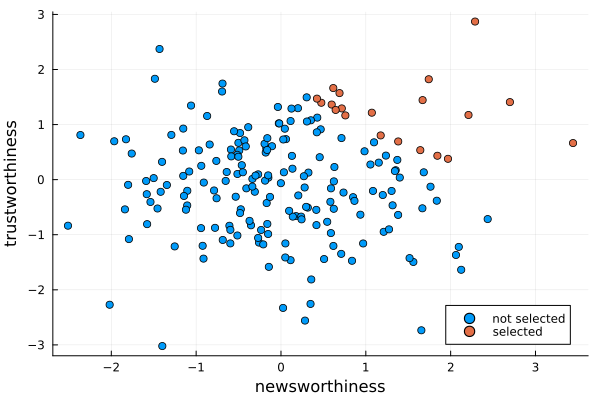

In [7]:
scatter(nw[.!selected], tw[.!selected]; xlab="newsworthiness", ylab="trustworthiness", label="not selected")
scatter!(nw[selected], tw[selected]; label="selected")

# 6.1 Multicollinearity

Code 6.2

In [49]:
Random.seed!(100)
N = 100
height = rand(Normal(10, 2), N)
leg_prop = rand(Uniform(0.4, 0.5), N)
leg_left = leg_prop .* height .+ rand(Normal(0, 0.02), N)
leg_right = leg_prop .* height .+ rand(Normal(0, 0.02), N)
d = DataFrame(:height => height, :leg_left => leg_left, :leg_right => leg_right);

In [50]:
d

Row,height,leg_left,leg_right
,Float64,Float64,Float64
1,12.1032,5.65868,5.65718
2,8.64629,4.01533,4.00513
3,9.66591,4.30533,4.33334
4,8.11308,4.01331,4.00048
5,10.0874,4.66227,4.62295
6,9.23638,3.76352,3.74656
7,8.53621,3.6824,3.69573
8,11.6993,5.46251,5.42911
9,10.7296,4.5173,4.53209


Code 6.3

In [9]:
@model function model_m6_1(leg_left, leg_right, height)
    a ~ Normal(10, 100)
    bl ~ Normal(2, 10)
    br ~ Normal(2, 10)
    μ = @. a + bl * leg_left + br * leg_right
    σ ~ Exponential(1)
    height ~ MvNormal(μ, σ)
end

m6_1 = sample(model_m6_1(d.leg_left, d.leg_right, d.height), NUTS(), 1000)
m6_1_df = DataFrame(m6_1)
precis(m6_1_df)

┌───────┬───────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%     histogram │
├───────┼───────────────────────────────────────────────────────┤
│     a │ 0.6958  0.3111   0.1972  0.6922  1.2022  ▁▁▂▄▇█▆▄▂▁▁▁ │
│    bl │ 0.2613  1.8473  -2.7113  0.2101  3.2291   ▁▂▃▆██▇▅▂▁▁ │
│    br │ 1.7976  1.8438  -1.1808  1.8267  4.7893   ▁▁▂▄▇██▆▃▂▁ │
│     σ │ 0.6118  0.0423   0.5492  0.6078   0.686       ▁▂██▃▁▁ │
└───────┴───────────────────────────────────────────────────────┘


Code 6.4

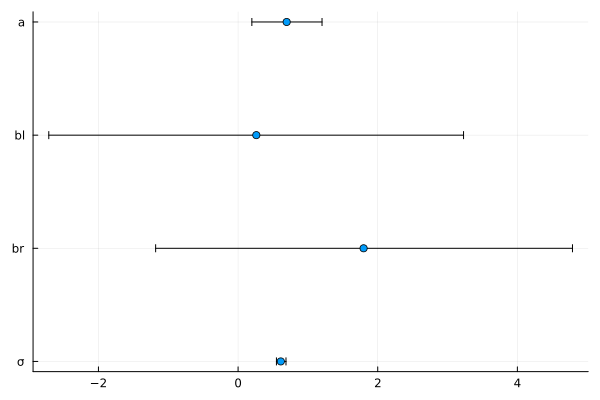

In [10]:
coeftab_plot(m6_1_df)

Code 6.5

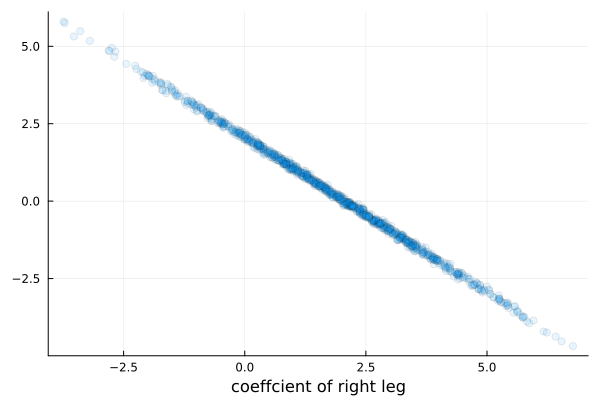

In [51]:
scatter(m6_1_df.br, m6_1_df.bl; alpha=0.1, xlab="coeffcient of right leg")

Code 6.6

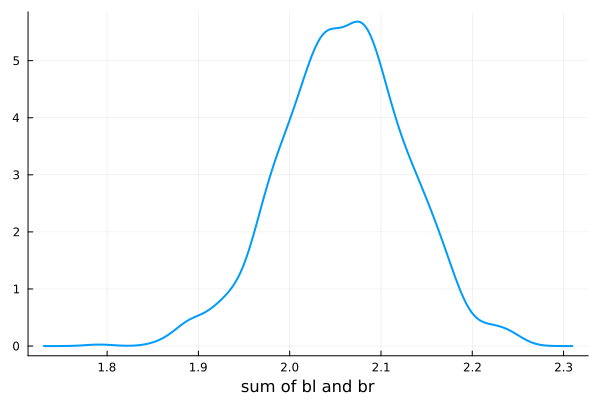

In [12]:
@df m6_1_df density(:br + :bl; lw=2, xlab="sum of bl and br")

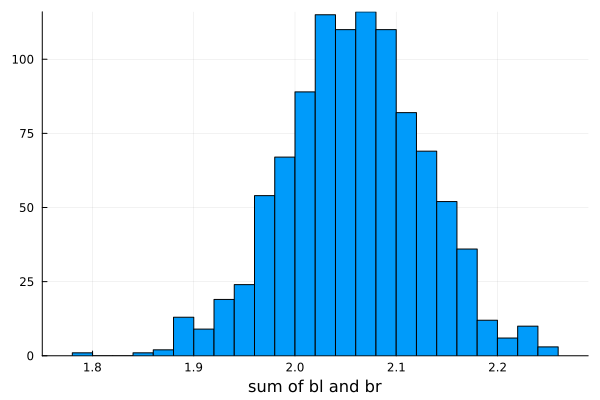

In [43]:
@df m6_1_df histogram(:br + :bl; xlab="sum of bl and br")

Code 6.7

In [13]:
@model function model_m6_2(leg_left, height)
    a ~ Normal(10, 100)
    bl ~ Normal(2, 10)
    μ = @. a + bl * leg_left
    σ ~ Exponential(1)
    height ~ MvNormal(μ, σ)
end

m6_2 = sample(model_m6_2(d.leg_left, d.height), NUTS(), 1000)
m6_2_df = DataFrame(m6_2)
precis(m6_2_df)

┌───────┬────────────────────────────────────────────────────┐
│ param │   mean     std    5.5%     50%   94.5%   histogram │
├───────┼────────────────────────────────────────────────────┤
│     a │ 0.7048  0.2726  0.2744  0.7069  1.1388  ▁▁▁▃▆█▇▄▁▁ │
│    bl │ 2.0559  0.0605  1.9629  2.0527  2.1583   ▁▁▄██▅▂▁▁ │
│     σ │ 0.6098  0.0423  0.5435  0.6088  0.6784     ▁▂▇█▄▁▁ │
└───────┴────────────────────────────────────────────────────┘


In [14]:
std(m6_1_df.bl), std(m6_1_df.br), std(m6_1_df.bl + m6_1_df.br)

(1.8472896861341155, 1.8437645807298166, 0.06854072941799996)

Code 6.8

In [52]:
d = DataFrame(CSV.File("data/milk.csv",  missingstring="NA"))

# get rid of dots in column names
rename!(n -> replace(n, "." => "_"), d)

d[!,:K] = standardize(ZScoreTransform, d.kcal_per_g)
d[!,:F] = standardize(ZScoreTransform, d.perc_fat)
d[!,:L] = standardize(ZScoreTransform, d.perc_lactose);

Code 6.9

In [16]:
@model function model_m6_3(F, K)
    a ~ Normal(0, 0.2)
    bF ~ Normal(0, 0.5)
    μ = @. a + F * bF
    σ ~ Exponential(1)
    K ~ MvNormal(μ, σ)
end

m6_3 = sample(model_m6_3(d.F, d.K), NUTS(), 1000)
m6_3_df = DataFrame(m6_3)

@model function model_m6_4(L, K)
    a ~ Normal(0, 0.2)
    bL ~ Normal(0, 0.5)
    μ = @. a + L * bL
    σ ~ Exponential(1)
    K ~ MvNormal(μ, σ)
end

m6_4 = sample(model_m6_4(d.L, d.K), NUTS(), 1000)
m6_4_df = DataFrame(m6_4)

precis(m6_3_df)
precis(m6_4_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%    histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │ -0.0001  0.0821  -0.1294  -0.0011  0.1311  ▁▂▃▆██▆▃▁▁▁ │
│    bF │  0.8603  0.0934   0.7091   0.8684  1.0004     ▁▁▅█▇▂▁▁ │
│     σ │  0.4882  0.0693   0.3912   0.4801  0.6105   ▁▃▇█▇▃▂▁▁▁ │
└───────┴────────────────────────────────────────────────────────┘
┌───────┬───────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%     50%    94.5%   histogram │
├───────┼───────────────────────────────────────────────────────┤
│     a │  0.0009    0.07  -0.1066  0.0013   0.1158  ▁▁▂▆██▅▃▁▁ │
│    bL │ -0.9016   0.074  -1.0178  -0.901  -0.7803  ▁▁▂▆██▅▂▁▁ │
│     σ │   0.412  0.0584   0.3308  0.4066   0.5196    ▁▄██▄▂▁▁ │
└───────┴───────────────────────────────────────────────────────┘


Code 6.10

In [17]:
@model function model_m6_5(F, L, K)
    a ~ Normal(0, 0.2)
    bF ~ Normal(0, 0.5)
    bL ~ Normal(0, 0.5)
    μ = @. a + F * bF + L * bL
    σ ~ Exponential(1)
    K ~ MvNormal(μ, σ)
end

m6_5 = sample(model_m6_5(d.F, d.L, d.K), NUTS(), 1000)
m6_5_df = DataFrame(m6_5)
precis(m6_5_df)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│     a │ -0.0013  0.0737  -0.1202  -0.0003   0.1167     ▁▁▁▂▅██▅▂▁▁ │
│    bF │  0.2581  0.1862  -0.0387   0.2515   0.5582  ▁▁▁▁▃▅▆█▇▅▃▁▁▁ │
│    bL │ -0.6646  0.1925  -0.9699  -0.6633  -0.3629        ▁▁▅█▆▂▁▁ │
│     σ │  0.4143  0.0613   0.3272   0.4081   0.5178       ▁▄██▅▂▁▁▁ │
└───────┴────────────────────────────────────────────────────────────┘


Code 6.11

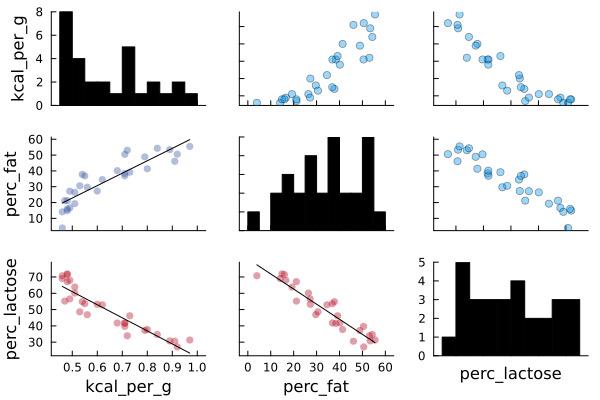

In [18]:
@df d corrplot([:kcal_per_g :perc_fat :perc_lactose]; seriestype=:scatter, bins=10, grid=false)

In [44]:
parentmodule(corrplot)

StatsPlots

## Code 6.12 Simulating collinearity

size(r_seq) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (100,)
size(stderr_x) = (1

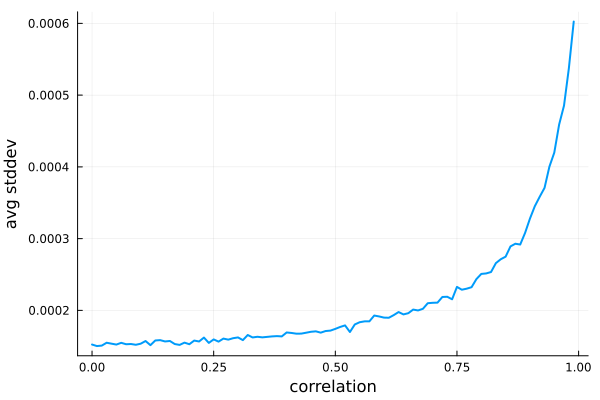

In [47]:
# get mean stderr for linear model's scale
function stderr_for_r(r)
    σ = sqrt(1-r^2)*var(d.perc_fat)
    fat_scaled = r .* d.perc_fat
    stderr_x = [
        begin
            x = d.perc_fat .+ rand(MvNormal(fat_scaled, σ))
            # add the intercept to the model
            X = hcat(ones(length(x)), x)
            m = lm(X, d.kcal_per_g)
            stderror(m)[2]
        end
        for _ in 1:100
    ]
    @show size(stderr_x)
    s = mean(stderr_x)
end


r_seq = range(0, 0.99; step=0.01)
@show size(r_seq)
s = stderr_for_r.(r_seq)
@show size(s)
plot(r_seq, s; lw=2, xlab="correlation", ylab="avg stddev")

# 6.2 Post-treatment bias

## Code 6.13

In [53]:
Random.seed!(70)
# number of plants
N = 100
h0 = rand(Normal(10, 2), N)
treatment = repeat(0:1, inner=div(N, 2))
fungus = [rand(Binomial(1, 0.5 - treat*0.4)) for treat in treatment]
h1 = h0 .+ rand(MvNormal(5 .- 3 .* fungus, 1))

d = DataFrame(:h0 => h0, :h1 => h1, :treatment => treatment, :fungus => fungus)
precis(d)

┌───────────┬───────────────────────────────────────────────────────────┐
│     param │    mean     std     5.5%      50%    94.5%      histogram │
├───────────┼───────────────────────────────────────────────────────────┤
│        h0 │ 10.0658   1.985   6.2772  10.1557  13.2044    ▂▁▃▄▇█▄▂▃▁▁ │
│        h1 │ 14.2651  2.5887  10.2287  14.2584  18.6671  ▂▂▃▄▄██▇▄▂▃▂▁ │
│ treatment │     0.5  0.5025      0.0      0.5      1.0    █▁▁▁▁▁▁▁▁▁█ │
│    fungus │    0.31  0.4648      0.0      0.0      1.0    █▁▁▁▁▁▁▁▁▁▄ │
└───────────┴───────────────────────────────────────────────────────────┘


In [54]:
d

Row,h0,h1,treatment,fungus
,Float64,Float64,Int64,Int64
1,11.0044,11.5254,0,1
2,7.82768,8.98684,0,1
3,13.2195,16.715,0,1
4,9.93586,12.1234,0,1
5,13.7586,15.8502,0,1
6,9.28593,14.0608,0,1
7,10.8124,13.3009,0,1
8,10.3692,12.6093,0,1
9,5.91469,11.7233,0,0


## Code 6.14

In [21]:
sim_p = rand(LogNormal(0, 0.25), 10_000)
precis(DataFrame(:sim_p => sim_p))

┌───────┬──────────────────────────────────────────────────────┐
│ param │   mean     std    5.5%     50%   94.5%     histogram │
├───────┼──────────────────────────────────────────────────────┤
│ sim_p │ 1.0326  0.2634  0.6697  1.0015  1.4921  ▁▁▅█▇▄▂▁▁▁▁▁ │
└───────┴──────────────────────────────────────────────────────┘


Code 6.15

In [22]:
@model function model_m6_6(h0, h1)
    p ~ LogNormal(0, 0.25)
    σ ~ Exponential(1)
    μ = h0 .* p
    h1 ~ MvNormal(μ, σ)
end

m6_6 = sample(model_m6_6(d.h0, d.h1), NUTS(), 1000)
m6_6_df = DataFrame(m6_6)
precis(m6_6_df)

┌───────┬───────────────────────────────────────────────────────┐
│ param │   mean     std    5.5%     50%   94.5%      histogram │
├───────┼───────────────────────────────────────────────────────┤
│     p │ 1.3992  0.0181  1.3704  1.3992  1.4277  ▁▁▂▄▆██▆▃▂▁▁▁ │
│     σ │ 1.9423  0.1378  1.7257  1.9388  2.1781     ▁▁▄▇█▆▃▁▁▁ │
└───────┴───────────────────────────────────────────────────────┘


## Code 6.16 m6_7, include both treatment and fungus

In [23]:
@model function model_m6_7(h0, treatment, fungus, h1)
    a ~ LogNormal(0, 0.2)
    bt ~ Normal(0, 0.5)
    bf ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    p = @. a + bt*treatment + bf*fungus
    μ = h0 .* p
    h1 ~ MvNormal(μ, σ)
end

m6_7 = sample(model_m6_7(d.h0, d.treatment, d.fungus, d.h1), NUTS(), 1000)
m6_7_df = DataFrame(m6_7)
precis(m6_7_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │  1.4913  0.0253   1.4492   1.4912   1.5325       ▁▃▆█▇▃▁▁ │
│    bf │ -0.2927  0.0305  -0.3433  -0.2916  -0.2458    ▁▁▂▄▇█▇▄▁▁▁ │
│    bt │   0.019  0.0296  -0.0255   0.0183   0.0677     ▁▁▂▆█▇▅▂▁▁ │
│     σ │  1.2669  0.0917   1.1321   1.2599   1.4193  ▁▁▃▆██▅▄▂▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


## Code 6.17 m6_8 (Include only treatment). Influence of Treatment is blocked by consequence (fungus)

In [24]:
@model function model_m6_8(h0, treatment, h1)
    a ~ LogNormal(0, 0.2)
    bt ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    p = @. a + bt*treatment
    μ = h0 .* p
    h1 ~ MvNormal(μ, σ)
end

@time m6_8 = sample(model_m6_8(d.h0, d.treatment, d.h1), NUTS(), 1000)
@time m6_8_df = DataFrame(m6_8)
describe(m6_8_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │   mean     std    5.5%     50%   94.5%       histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │ 1.3191  0.0249  1.2788  1.3194  1.3592       ▁▁▂▅██▄▂▁ │
│    bt │  0.162  0.0346   0.106  0.1615  0.2175  ▁▁▁▂▃▅██▆▃▂▁▁▁ │
│     σ │ 1.7683  0.1329  1.5615  1.7631  1.9866      ▁▃▆█▇▃▂▁▁▁ │
└───────┴────────────────────────────────────────────────────────┘


## Code 6.18 T(reatment) influences F(ungus), which influences H(eight).

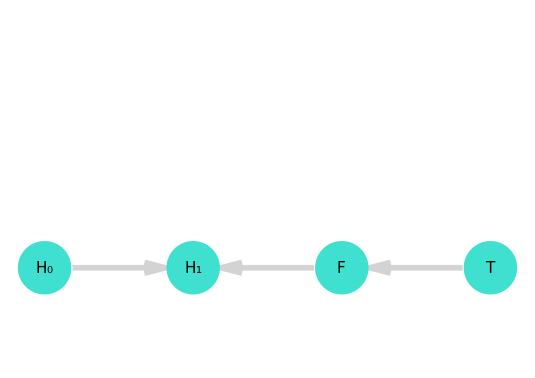

In [25]:
plant_dag = Dagitty.DAG(:H₀ => :H₁, :F => :H₁, :T => :F)
drawdag(plant_dag, [2, 0, 1, 3], [0, 0, 0, 0])

## Code 6.19 Implied conditional independence



In [26]:
implied_conditional_independencies_min(plant_dag)

LoadError: UndefVarError: `implied_conditional_independencies_min` not defined

Code 6.20

In [27]:
Random.seed!(70)
# number of plants
N = 1000
h0 = rand(Normal(10, 2), N)
treatment = repeat(0:1, inner=div(N, 2))
M = rand(Bernoulli(), N)
fungus = [
    rand(Binomial(1, 0.5 - treat*0.4 + 0.4 * m)) 
    for (treat, m) ∈ zip(treatment, M)
]
h1 = h0 .+ rand(MvNormal(5 .+ 3 .* M, 1))

d2 = DataFrame(:h0 => h0, :h1 => h1, :treatment => treatment, :fungus => fungus)
precis(d2)

┌───────────┬─────────────────────────────────────────────────────────┐
│     param │    mean     std     5.5%      50%    94.5%    histogram │
├───────────┼─────────────────────────────────────────────────────────┤
│        h0 │ 10.1048  2.0042   6.9227  10.1215  13.2466    ▁▁▁▃██▄▁▁ │
│        h1 │  16.625  2.6326  12.3645  16.6637  20.8697    ▁▁▄▇█▆▃▁▁ │
│ treatment │     0.5  0.5003      0.0      0.5      1.0  █▁▁▁▁▁▁▁▁▁█ │
│    fungus │   0.504  0.5002      0.0      1.0      1.0  █▁▁▁▁▁▁▁▁▁█ │
└───────────┴─────────────────────────────────────────────────────────┘


In [28]:
m6_7 = sample(model_m6_7(d2.h0, d2.treatment, d2.fungus, d2.h1), NUTS(), 1000)
precis(DataFrame(m6_7))

┌───────┬──────────────────────────────────────────────────────┐
│ param │   mean     std    5.5%     50%   94.5%     histogram │
├───────┼──────────────────────────────────────────────────────┤
│     a │ 1.5222  0.0137   1.501  1.5225  1.5432  ▁▁▁▄██▆▃▁▁▁▁ │
│    bf │  0.135  0.0139   0.113  0.1346  0.1579    ▁▁▁▄▇█▅▄▁▁ │
│    bt │ 0.0593  0.0148  0.0352  0.0596  0.0819    ▁▁▃▆██▆▃▁▁ │
│     σ │ 2.1352  0.0451  2.0636  2.1353  2.2091       ▁▁▄█▆▂▁ │
└───────┴──────────────────────────────────────────────────────┘


In [29]:
m6_8 = sample(model_m6_8(d2.h0, d2.treatment, d2.h1), NUTS(), 1000)
precis(DataFrame(m6_8))

┌───────┬────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%  histogram │
├───────┼────────────────────────────────────────────────────┤
│     a │ 1.6194  0.0097   1.6035  1.6193  1.6354   ▁▁▃█▇▃▁▁ │
│    bt │ 0.0004  0.0138  -0.0199  0.0002  0.0229  ▁▁▂▆██▅▂▁ │
│     σ │ 2.2206  0.0478    2.144   2.221  2.2944    ▁▂▆█▅▁▁ │
└───────┴────────────────────────────────────────────────────┘


# 6.3 Collider bias

## Code 6.21 Simulate Happiness -> Marriage <- Age

In [55]:
d = sim_happiness(seed=1977, n_years=1000)
precis(d)

┌───────────┬────────────────────────────────────────────────────────┐
│     param │   mean      std     5.5%   50%   94.5%       histogram │
├───────────┼────────────────────────────────────────────────────────┤
│       age │   33.0  18.7689      4.0  33.0    62.0  ▇████████████▂ │
│ happiness │   -0.0   1.2144  -1.7895   0.0  1.7895       █▆█▆▆█▆▆▃ │
│   married │ 0.2854   0.4518      0.0   0.0     1.0     █▁▁▁▁▁▁▁▁▁▄ │
└───────────┴────────────────────────────────────────────────────────┘


In [57]:
@show size(d)
@show first(d,3)
last(d,3)

size(d) = (1300, 3)
first(d, 3) = 3×3 DataFrame
 Row │ age    happiness  married
     │ Int64  Float64    Int64
─────┼───────────────────────────
   1 │    65   -2.0            0
   2 │    65   -1.78947        0
   3 │    65   -1.57895        0


Row,age,happiness,married
,Int64,Float64,Int64
1,1,1.57895,0
2,1,1.78947,0
3,1,2.0,0


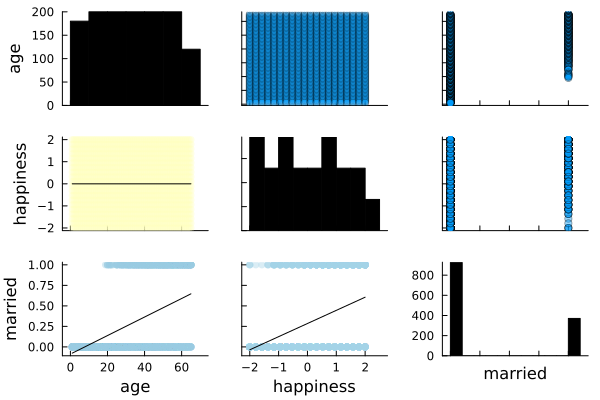

In [58]:
@df d corrplot([:age :happiness :married]; seriestype=:scatter, bins=10, grid=false)

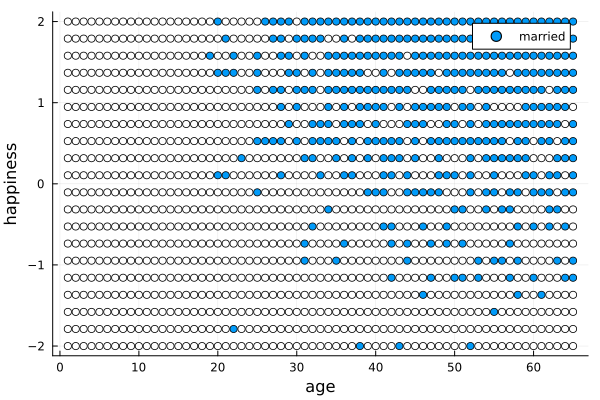

In [31]:
d_m = d[d.married .== 1,[:age,:happiness]]
d_u = d[d.married .== 0,[:age,:happiness]]

scatter(d_m.age, d_m.happiness; label="married", xlab="age", ylab="happiness")
scatter!(d_u.age, d_u.happiness; c=:white)

### Code 6.22 Pick the adults only and normaliz Age

In [32]:
d2 = d[d.age .> 17,:]
d2[!,:A] = @. (d2.age - 18) / (65-18);

### Code 6.23  Happiness conditioned on Marital status and Age

In [33]:
d2[!,:mid] = d2.married .+ 1;

In [34]:
@model function model_m6_9(mid, A, happiness)
    a ~ MvNormal([0, 0], 1)
    bA ~ Normal(0, 2)
    μ = a[mid] .+ bA .* A
    σ ~ Exponential(1)
    happiness ~ MvNormal(μ, σ)
end

m6_9 = sample(model_m6_9(d2.mid, d2.A, d2.happiness), NUTS(), 1000)
m6_9_df = DataFrame(m6_9)
precis(m6_9_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%    histogram │
├───────┼─────────────────────────────────────────────────────────┤
│  a[1] │ -0.1951  0.0635  -0.2945  -0.1966  -0.0868    ▁▂▄██▄▂▁▁ │
│  a[2] │   1.288  0.0888   1.1482   1.2859   1.4333  ▁▁▂▄██▇▆▃▂▁ │
│    bA │ -0.7582  0.1137  -0.9531  -0.7559  -0.5754     ▁▁▂▅█▅▂▁ │
│     σ │  1.0014  0.0238   0.9636   1.0012   1.0387    ▁▁▄██▄▁▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


- Age has negative effect on Happiness ?!

### Code 6.24 Happiness conditioned on Age alone

In [35]:
@model function model_m6_10(A, happiness)
    a ~ Normal()
    bA ~ Normal(0, 2)
    μ = a .+ bA .* A
    σ ~ Exponential(1)
    happiness ~ MvNormal(μ, σ)
end

m6_10 = sample(model_m6_10(d2.A, d2.happiness), NUTS(), 1000)
m6_10_df = DataFrame(m6_10)
precis(m6_10_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%    histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │  0.0029   0.079  -0.1173   0.0027  0.1241  ▁▁▃▆██▇▄▁▁▁ │
│    bA │ -0.0045  0.1387  -0.2175  -0.0039  0.2094   ▁▁▂▆██▆▂▁▁ │
│     σ │  1.2163  0.0264   1.1728    1.218   1.258   ▁▁▃▆██▄▂▁▁ │
└───────┴────────────────────────────────────────────────────────┘


- Age has no effect on Happiness !

## Code 6.25 Influence of Grandparent, Parent, Unmeasured (neighborhood) on Child's education level

In [60]:
N = 200
b_GP = 1
b_GC = 0
b_PC = 1
b_U = 2;

### Code 6.26 Simulate data

In [61]:
Random.seed!(6)
U = 2 .* rand(Bernoulli(), N) .- 1
G = rand(Normal(), N)
P = rand(MvNormal(@. b_GP*G + b_U*U))
C = rand(MvNormal(@. b_PC*P + b_GC*G + b_U*U))
d = DataFrame(:C => C, :P => P, :G => G, :U => U);

### Code 6.27 Child education level conditioned on Parent and Grandparent

In [62]:
@model function model_m6_11(P, G, C)
    a ~ Normal()
    b_PC ~ Normal()
    b_GC ~ Normal()
    μ = @. a + b_PC*P + b_GC*G
    σ ~ Exponential(1)
    C ~ MvNormal(μ, σ)
end

m6_11 = sample(model_m6_11(d.P, d.G, d.C), NUTS(), 1000)
m6_11_df = DataFrame(m6_11)
precis(m6_11_df)

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%      histogram │
├───────┼──────────────────────────────────────────────────────────┤
│     a │  0.2093  0.1927  -0.1074   0.2112  0.5232  ▁▁▁▂▄▆██▇▄▂▁▁ │
│  b_GC │  0.4216  0.2123   0.0928   0.4151  0.7638       ▁▁▃██▄▁▁ │
│  b_PC │ -0.0977  0.0911  -0.2416  -0.0969  0.0449  ▁▁▂▄▆██▇▅▂▁▁▁ │
│     σ │  2.7777  0.1365   2.5729   2.7699  3.0007     ▁▁▃▆█▇▄▂▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


- Grandparent effect is 0.42, not 0?
- Parent effect is almost 0, not 1?

### Code 6.28 Child education level conditioned on Parent, Grandparent, and Unmeasured factor (neighborhood)

In [63]:
@model function model_m6_12(P, G, U, C)
    a ~ Normal()
    b_PC ~ Normal()
    b_GC ~ Normal()
    b_U ~ Normal()
    μ = @. a + b_PC*P + b_GC*G + b_U*U
    σ ~ Exponential(1)
    C ~ MvNormal(μ, σ)
end

m6_12 = sample(model_m6_12(d.P, d.G, d.U, d.C), NUTS(), 1000)
m6_12_df = DataFrame(m6_12)
precis(m6_12_df)

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%      histogram │
├───────┼──────────────────────────────────────────────────────────┤
│     a │  0.2057  0.2003  -0.1212    0.209  0.5338  ▁▁▁▂▄▆██▆▄▃▁▁ │
│  b_GC │  0.3946  0.2031   0.0812    0.392  0.7202   ▁▁▃▅████▅▃▁▁ │
│  b_PC │ -0.1031  0.0886  -0.2549  -0.1026   0.036  ▁▁▂▃▆██▆▃▂▁▁▁ │
│   b_U │ -0.1634  0.1961  -0.4721  -0.1658  0.1702       ▁▁▃▇█▄▁▁ │
│     σ │  2.7822  0.1476    2.558   2.7748  3.0395     ▁▁▃▆█▇▄▂▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


# 6.4 Confronting confounding

## Code 6.29

In [40]:
dag_61 = Dagitty.DAG(
    :X => :Y,
    :U => :X, :A => :U,
    :A => :C, :C => :Y,
    :U => :B, :C => :B,
)

all_backdoor_adjustment_sets(dag_61, :X, :Y)

LoadError: UndefVarError: `all_backdoor_adjustment_sets` not defined

Code 6.30

In [41]:
dag_62 = Dagitty.DAG(
    :A => :D,
    :A => :M, :M => :D,
    :S => :A, :S => :M,
    :S => :W, :W => :D,
)
all_backdoor_adjustment_sets(dag_62, :W, :D)

LoadError: UndefVarError: `all_backdoor_adjustment_sets` not defined

In [42]:
implied_conditional_independencies_min(dag_62)

LoadError: UndefVarError: `implied_conditional_independencies_min` not defined